In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris , make_multilabel_classification
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split

In [3]:
# Creating a class for each type of node
class MultGate():
  def forward(self,x,y):
    z = np.dot(x,y)
    self.x = x
    self.y = y
    return z
  def backward(self,dz):
    dx = self.y*dz
    dy = self.x*dz
    return [dx,dy]

class AddGate():
  def forward(self,x,y):
    self.x = x
    self.y = y
    z = np.add(x,y) 
    return z
  def backward(self,dz):
    return [dz,dz]

class SigmoidGate():
  def forward(self,x):
    self.x = x
    return 1/(1 + np.exp(-x))
  def backward(self,x):
    self.x = x
    return x * (1 - x)

class SoftmaxGate(): 
  def forward(self,x):
    self.x = x
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps/np.sum(exps, axis=1, keepdims=True)

class CrossEntropyGate():
  def forward(self,x,y):
    self.x = x
    self.y = y
    l = -np.log(x[0,y])
    loss = np.sum(l)
    return loss
  def backward(self,x,y):
    self.x = x
    self.y = y
    n_samples = y.shape[0]
    res = x - y
    return res/n_samples


In [ ]:
# Creating a class for the model and defining the front and back propagation
class model():    
    def __init__(self, x, y,neurons):
        self.x = x
        self.lr = 0.001
        self.decayRate = 0.002
        ip_dim = x.shape[1]
        op_dim = 3
        self.loss=[]
        self.loss_mean=[]

        self.w1 = np.random.randn(ip_dim, neurons)
        self.b1 = np.zeros((1, neurons))
        self.multiply1 = MultGate()
        self.addition1 = AddGate()
        self.sigmoid1 = SigmoidGate()
        
        self.w2 = np.random.randn(neurons, neurons)
        self.b2 = np.zeros((1, neurons))
        self.multiply2 = MultGate()
        self.addition2 = AddGate()
        self.sigmoid2 = SigmoidGate()

        self.w3 = np.random.randn(neurons, 3)
        self.b3 = np.zeros((1, 3))
        self.multiply3 = MultGate()
        self.addition3 = AddGate()
        self.softmax = SoftmaxGate()
        self.cross_entropy = CrossEntropyGate()
        self.y = y

    def forward(self,x,y):
        m1 = self.multiply1.forward(x,self.w1)
        z1 = self.addition1.forward(m1,self.b1)
        self.a1 = self.sigmoid1.forward(z1)
        m2 = self.multiply1.forward(self.a1,self.w2)
        z2 = self.addition1.forward(m2,self.b2)
        self.a2 = self.sigmoid2.forward(z2)
        m3 = self.multiply1.forward(self.a2,self.w3)
        z3 = self.addition1.forward(m3,self.b3)
        self.a3 = self.softmax.forward(z3)
        loss = self.cross_entropy.forward(self.a3,y)
        return loss

    def backward(self,x,y):
        dloss_yh = self.cross_entropy.backward(self.a3, y)
        dloss_z2 = np.dot(dloss_yh, self.w3.T)
        dloss_a2 = dloss_z2 * self.sigmoid2.backward(self.a2)
        dloss_z1 = np.dot(dloss_a2, self.w2.T)
        self.lr*= (1.0 / (1.0 + (self.decayRate * 1)))
        dloss_a1 = dloss_z1 * self.sigmoid1.backward(self.a1)
        self.w3 -= self.lr * np.dot(self.a2.T, dloss_yh)
        self.b3 -= self.lr * np.sum(dloss_yh, axis=0, keepdims=True)
        self.w2 -= self.lr * np.dot(self.a1.T, dloss_a2)
        self.b2 -= self.lr * np.sum(dloss_a2, axis=0)
        self.w1 -= self.lr * np.dot(x.T, dloss_a1)
        self.b1 -= self.lr * np.sum(dloss_a1, axis=0)

In [4]:
# Predicting using the model and testing the accuracy
def predict(self, data,y):
        self.x = data
        self.forward(data,y)
        return self.a3.argmax()
def get_acc(x, y):
    acc = 0
    for xx,yy in zip(x, y):
        pred = modelx.predict(xx,y)
        if pred == np.argmax(yy):
            acc +=1
    return 100*acc/len(x)

In [5]:
# Functions used to load the data.
def one_hot_encoding(labels):
    return pd.get_dummies(labels)

def loadIrisDataset():
    iris = load_iris()
    x = iris.data
    y = one_hot_encoding(iris.target)
    x = np.array(iris.data)
    mean = x.mean(axis=0)
    std = x.std(axis=0)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    x_train -= mean
    x_train /= std
    x_test -= mean
    x_test /= std
    y_train=np.array(y_train)
    y_test=np.array(y_test)
    return x_train, x_test, y_train, y_test

def loadRandomDataset():
    x,y = make_multilabel_classification(n_samples=200,n_features=4,n_classes=3,n_labels=1,allow_unlabeled=False)
    x = np.array(x)
    mean = x.mean(axis=0)
    std = x.std(axis=0)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    x_train -= mean
    x_train /= std
    x_test -= mean
    x_test /= std
    y_train=np.array(y_train)
    y_test=np.array(y_test)
    return x_train, x_test, y_train, y_test

# Functions used to plot the data  
def plot(a,b):
    loss = a.loss_mean
    epochs = range(1,len(loss) + 1)
    plt.plot(epochs,loss,label='training loss')
    plt.title(str(b))
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.figure()

Training accuracy:  46.666666666666664
Test accuracy:  57.77777777777778
Training accuracy:  33.333333333333336
Test accuracy:  31.11111111111111
Training accuracy:  45.714285714285715
Test accuracy:  53.333333333333336
Training accuracy:  58.095238095238095
Test accuracy:  57.77777777777778
Training accuracy:  80.0
Test accuracy:  91.11111111111111
The number of neurons in the hidden layer:  104


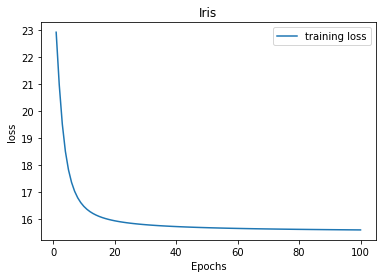

<Figure size 432x288 with 0 Axes>

In [11]:
x_train, x_test, y_train, y_test = loadIrisDataset() #Change the dataset here


#Testing models an increasing the number of neurons until accuracy is > 90%
epochs = 100
done = False
for i in (2**p for p in range(4, 11)):
    modelx = model(x_train, y_train,i)
    for x in range(epochs):
        for i in range(x_train.shape[0]):
            loss = modelx.forward(x_train[i].reshape(1,x_train.shape[1]),y_train[i])
            modelx.backward(x_train[i].reshape(1,x_train.shape[1]),y_train[i])
            modelx.loss.append(loss)
        modelx.loss_mean.append(np.mean(modelx.loss))
    if get_acc(x_test, y_test) >90:
      done = True
      print("Training accuracy: ", get_acc(x_train,y_train))
      print("Test accuracy: ", get_acc(x_test, y_test))
      print("The number of neurons in the hidden layer: ", i)
      break
    print("Training accuracy: ", get_acc(x_train,y_train))
    print("Test accuracy: ", get_acc(x_test, y_test))
if not done:
    print("The number of neurons in the hidden layer: ", i)
plot(modelx,"Iris")